# 🐶🐱 Final AP Computer Science Principles Project  
### **By Michael Wu**

In this project, I develop a moderately deep Convolutional Neural Network (CNN) with Residual Units (~20 layers) to classify images of **dogs** and **cats**. The ultimate goal is to create an approach that will accurately classify images of dogs or cats fed into the ML model.

📂 **Dataset**: [Dogs vs. Cats (Kaggle Competition)](https://www.kaggle.com/competitions/dogs-vs-cats/overview)



The steps enumerated below are the main idea for training and testing:

`1. Load in Data/Visualize Data`

`2. Do data transformations/turn images into tensors for training`

`3. Create the Machine Learning Model `

`4. Train the model for n epochs`

`5. Evaluate the model`

`6. Save the trained weights`

`7. Predict! `


In [3]:
# Import the necessary modules 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import os
import tqdm
import random
import numpy as np

# Step 1: Load in and visualize the images

The main purpose of this cell is to visualize images of dogs and cats.



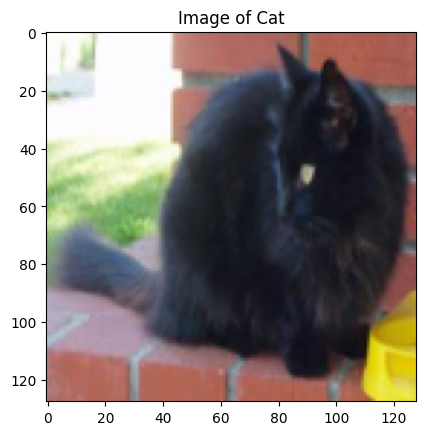

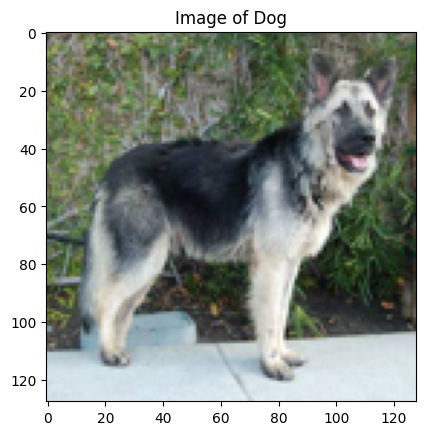

In [2]:
# Define the root directory
root_dir = "/path/to/your/train"
cat_dir = os.path.join(root_dir, "cats")
dog_dir = os.path.join(root_dir, "dogs")
cat_images = os.listdir(cat_dir)
dog_images = os.listdir(dog_dir)

# Randomly select an index for a cat and dog image
index_value = random.randint(0, len(cat_images) - 1)

# The images are already in PIL format. We can visualize a random image
# You can also specify deterministic images
#random.seed(123456420)
index_value = random.randint(0, len(cat_images)-1) #Length of cat== length of dog

cat_img_to_plot = Image.open(os.path.join(cat_dir, cat_images[index_value])).resize((128,128))
dog_img_to_plot = Image.open(os.path.join(dog_dir, dog_images[index_value])).resize((128,128))

# Start plotting the images!

plt.title("Image of Cat")
plt.imshow(cat_img_to_plot)
plt.show()

plt.title("Image of Dog")
plt.imshow(dog_img_to_plot)
plt.show()


# Step 2: Prepare the data for training via data transformations

In PyTorch, the images need to be in tensor format `[channels, row, column]` in order for training to happen.

The below steps detail the workflow:

Load in data using `torchvision.datasets.ImageFolder` as our data is already in the typical classification format.


The below cell will do the following transformations:

`1. Resize all images to be (224, 224)`

`2. Random Horizonal Flip`

`3. Turn Images into Tensors`

`4. Normalize the data (tricky) so I will use the imagenet dataset value`



In [37]:
from torch.utils.data import random_split

torch.manual_seed(42)
# This transform is for the model pipeline described above. 
# The Normalization values are chosen arbitrary as calculating it is difficult
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  # Light augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])


# The pytorch already has a class called ImageFolder that can process data in the format of classification
data = datasets.ImageFolder(root="/path/to/your/train", transform=transform)

# Creating a training and a validation data during training
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_dataset, val_dataset = random_split(data, [train_size, val_size])

# Will feed this for training. Batch_size=16 for less memory usage 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=10)

#Cats are 0
# Dogs are 1
print(data.class_to_idx)

{'cats': 0, 'dogs': 1}


In [ ]:
# Have a glimpse at the data. 
# The training images have a shape of 64 batches, 3 color channels, and a row and column size of 128
# Takes a bit of time
images, labels = next(iter(train_loader))

print(images.shape, labels.shape)

# Step 3: Create the Machine Learning Model

I will create a 2d CNN model. This model will have multiple layers and will consist of `n` conv blocks. Additionally, the model will also feature skipped connections such as the famous `resnet`, by `He Kaiming`, model to improve training by smoothing the gradients. 

The model will also have `batchnorm and maxpool` for training improvement by reducing dimentions and improved convergence

In [4]:
import torch
import torch.nn as nn
from torchinfo import summary

# This class implements cnn blocks with a residual connection to improve training
class CNNLayer(nn.Module):
    def __init__(self, n_channels):
        super().__init__()

        # Conv block 1
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(num_features=n_channels)
        self.ac1 = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.ac1(self.batch_norm1(self.conv1(x)))
        if residual.shape != out.shape:
            residual = nn.functional.adaptive_avg_pool2d(residual, output_size=out.shape[2:])
        return out + residual
    

class full_cnn(nn.Module):
    def __init__(self, n_layers, n_channels=32):
        super().__init__()

        # First conv block for the input channels of RGB (3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(num_features=n_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # You could switch to AdaptiveAvgPool2d if preferred
        self.act1 = nn.ReLU()

        # Create the convolutional layers with residual connections
        layers = []
        for _ in range(n_layers):
            layers.append(CNNLayer(n_channels))

        self.seq1 = nn.Sequential(*layers)

        # Global Average Pooling to reduce the feature map size before FC layers
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Output size after GAP will be (batch_size, n_channels, 1, 1)
        # Therefore, the number of features will simply be n_channels
        self.fc1 = nn.Linear(n_channels, 1024)  # You can adjust this number
        self.ac2 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        out = self.act1(self.pool1(self.batch_norm1(self.conv1(x))))
        out = self.seq1(out)

        # Apply Global Average Pooling to reduce the spatial size to 1x1
        out = self.gap(out)
        out = out.flatten(start_dim=1)  # Flatten to (batch_size, n_channels)

        out = self.ac2(self.fc1(out))
        out = self.fc2(out)
        return out


model = full_cnn(n_layers=10)
dummy_input = torch.randn(1, 3, 128, 128)
init_ll = model(dummy_input)
print(init_ll)

summary(model, input_size=(1, 3, 128, 128))


tensor([[-0.9216, -0.4124]], grad_fn=<AddmmBackward0>)


Layer (type:depth-idx)                   Output Shape              Param #
full_cnn                                 [1, 2]                    --
├─Conv2d: 1-1                            [1, 32, 128, 128]         896
├─BatchNorm2d: 1-2                       [1, 32, 128, 128]         64
├─MaxPool2d: 1-3                         [1, 32, 64, 64]           --
├─ReLU: 1-4                              [1, 32, 64, 64]           --
├─Sequential: 1-5                        [1, 32, 64, 64]           --
│    └─CNNLayer: 2-1                     [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 32, 64, 64]           9,248
│    │    └─BatchNorm2d: 3-2             [1, 32, 64, 64]           64
│    │    └─ReLU: 3-3                    [1, 32, 64, 64]           --
│    └─CNNLayer: 2-2                     [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-4                  [1, 32, 64, 64]           9,248
│    │    └─BatchNorm2d: 3-5             [1, 32, 64, 64]           64
│    │  

# Step 4: Define the training pipeline and hyperparameters

In this step I will define a loss function, optimizer, and a training function

For the optimizer I will use `ADAMw` as it has L2 regularization (weight decay) and adaptive learning rate

For the loss fn I will use `nn.CrossEntropyLoss()` which is a combination of `softmax and NLLLoss`. 

Doing this will need a `torch.argmax(dim=1) to get predicted class`


# Training the model takes quite a long time on MPS. I have not tried on other GPUs or CPUs. 

If you have macbook please use: `device = "mps" if torch.backends.mps.is_available() else "cpu"` 

If you have nvidia GPU pleaase use: `device = "cuda" if torch.cuda.is_available() else "cpu"`

I initially tried training on m3 pro, but the gpu power seems to be insufficient. Therefore, I ended up training on a 3060. If you have neither hardware you can use `google collab` as they have free nvidia t4.



In [9]:
#Set up device agnostic code

# Use if Apple
device = "mps" if torch.backends.mps.is_available() else "cpu" 

#Use if Nvidia
#device = "cuda" if torch.cuda.is_available() else "cpu" 
print(device)

mps


In [10]:
# Define optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay = 1e-2)

# Define loss fn
loss_fn = nn.CrossEntropyLoss()

In [11]:
import tqdm

def training_loop(n_epochs, optimizer, loss_fn, model, train_loader, val_loader):
    model.to(device)
    pbar = tqdm.tqdm(total=n_epochs * len(train_loader), desc="TRAINING PROCESS")  # Total steps for progress bar
    
    for epoch in range(1, n_epochs + 1):  # Iterate over the number of epochs
        # Model in train mode (dropout, etc)
        model.train()
        
        train_loss_value = 0.0
        val_loss_value = 0.0

        train_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs} [Training]", leave=False)

        for batch_idx, (imgs, labels) in enumerate(train_bar):
            imgs, labels = imgs.to(device), labels.to(device)
            
            prediction = model(imgs)
            train_loss = loss_fn(prediction, labels)
            train_loss_value += train_loss.item()

            # Calculate gradients and update the model parameters
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            # Update progress bar after each batch
            batch_loss = train_loss.item()
            train_bar.set_postfix(batch=batch_idx+1, loss=batch_loss)

            pbar.update(1)

        # Put model in evaluation mode for validation
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                val_prediction = model(imgs)
                val_loss = loss_fn(val_prediction, labels)
                val_loss_value += val_loss.item()

        print(f"EPOCH: {epoch} | Train_loss: {train_loss_value / len(train_loader):.3f} | Val_loss: {val_loss_value / len(val_loader):.3f}")
    
    pbar.close()

# Call the function
model.to(device)
training_loop(n_epochs=50, optimizer=optimizer, loss_fn=loss_fn, model=model, train_loader=train_loader, val_loader=val_loader)


TRAINING PROCESS:   2%|▏         | 1250/62500 [02:20<1:03:19, 16.12it/s]

EPOCH: 1 | Train_loss: 0.657 | Val_loss: 0.614


TRAINING PROCESS:   4%|▍         | 2500/62500 [05:20<1:01:37, 16.23it/s]  

EPOCH: 2 | Train_loss: 0.602 | Val_loss: 0.616


TRAINING PROCESS:   6%|▌         | 3750/62500 [08:30<59:52, 16.36it/s]    

EPOCH: 3 | Train_loss: 0.568 | Val_loss: 0.564


TRAINING PROCESS:   8%|▊         | 5000/62500 [11:30<56:47, 16.87it/s]    

EPOCH: 4 | Train_loss: 0.543 | Val_loss: 0.585


TRAINING PROCESS:  10%|█         | 6250/62500 [14:20<57:59, 16.17it/s]    

EPOCH: 5 | Train_loss: 0.522 | Val_loss: 0.505


TRAINING PROCESS:  12%|█▏        | 7500/62500 [17:10<54:16, 16.89it/s]    

EPOCH: 6 | Train_loss: 0.503 | Val_loss: 0.520


TRAINING PROCESS:  14%|█▍        | 8750/62500 [20:10<53:01, 16.90it/s]    

EPOCH: 7 | Train_loss: 0.478 | Val_loss: 0.463


TRAINING PROCESS:  16%|█▌        | 10000/62500 [23:01<52:34, 16.64it/s]   

EPOCH: 8 | Train_loss: 0.453 | Val_loss: 0.413


TRAINING PROCESS:  18%|█▊        | 11250/62500 [25:51<50:54, 16.78it/s]    

EPOCH: 9 | Train_loss: 0.423 | Val_loss: 0.591


TRAINING PROCESS:  20%|██        | 12500/62500 [28:41<49:45, 16.75it/s]    

EPOCH: 10 | Train_loss: 0.400 | Val_loss: 0.606


TRAINING PROCESS:  22%|██▏       | 13750/62500 [31:41<50:09, 16.20it/s]    

EPOCH: 11 | Train_loss: 0.384 | Val_loss: 0.825


TRAINING PROCESS:  24%|██▍       | 15000/62500 [34:41<52:32, 15.07it/s]    

EPOCH: 12 | Train_loss: 0.363 | Val_loss: 0.528


TRAINING PROCESS:  26%|██▌       | 16250/62500 [37:41<46:10, 16.70it/s]    

EPOCH: 13 | Train_loss: 0.347 | Val_loss: 0.293


TRAINING PROCESS:  28%|██▊       | 17500/62500 [40:51<44:19, 16.92it/s]    

EPOCH: 14 | Train_loss: 0.319 | Val_loss: 0.290


TRAINING PROCESS:  30%|███       | 18750/62500 [43:42<43:10, 16.89it/s]    

EPOCH: 15 | Train_loss: 0.314 | Val_loss: 0.387


TRAINING PROCESS:  32%|███▏      | 20000/62500 [46:42<41:49, 16.94it/s]    

EPOCH: 16 | Train_loss: 0.304 | Val_loss: 0.280


TRAINING PROCESS:  34%|███▍      | 21250/62500 [49:32<40:53, 16.81it/s]    

EPOCH: 17 | Train_loss: 0.290 | Val_loss: 0.297


TRAINING PROCESS:  36%|███▌      | 22500/62500 [52:42<40:36, 16.42it/s]    

EPOCH: 18 | Train_loss: 0.280 | Val_loss: 0.318


TRAINING PROCESS:  38%|███▊      | 23750/62500 [55:32<38:40, 16.70it/s]    

EPOCH: 19 | Train_loss: 0.271 | Val_loss: 0.243


TRAINING PROCESS:  40%|████      | 25000/62500 [58:32<37:43, 16.57it/s]    

EPOCH: 20 | Train_loss: 0.263 | Val_loss: 0.601


TRAINING PROCESS:  42%|████▏     | 26250/62500 [1:01:22<36:26, 16.58it/s]  

EPOCH: 21 | Train_loss: 0.249 | Val_loss: 0.255


TRAINING PROCESS:  44%|████▍     | 27500/62500 [1:04:23<35:14, 16.55it/s]    

EPOCH: 22 | Train_loss: 0.246 | Val_loss: 0.314


TRAINING PROCESS:  46%|████▌     | 28750/62500 [1:07:13<33:47, 16.64it/s]    

EPOCH: 23 | Train_loss: 0.240 | Val_loss: 0.360


TRAINING PROCESS:  48%|████▊     | 30000/62500 [1:10:13<34:34, 15.66it/s]    

EPOCH: 24 | Train_loss: 0.224 | Val_loss: 0.261


TRAINING PROCESS:  50%|█████     | 31250/62500 [1:13:03<30:52, 16.87it/s]    

EPOCH: 25 | Train_loss: 0.222 | Val_loss: 0.203


TRAINING PROCESS:  52%|█████▏    | 32500/62500 [1:15:53<29:57, 16.69it/s]    

EPOCH: 26 | Train_loss: 0.216 | Val_loss: 0.221


TRAINING PROCESS:  54%|█████▍    | 33750/62500 [1:18:53<28:30, 16.81it/s]    

EPOCH: 27 | Train_loss: 0.213 | Val_loss: 0.210


TRAINING PROCESS:  56%|█████▌    | 35000/62500 [1:21:43<27:05, 16.91it/s]    

EPOCH: 28 | Train_loss: 0.207 | Val_loss: 0.204


TRAINING PROCESS:  58%|█████▊    | 36250/62500 [1:24:44<26:58, 16.22it/s]    

EPOCH: 29 | Train_loss: 0.199 | Val_loss: 0.183


TRAINING PROCESS:  60%|██████    | 37500/62500 [1:27:34<25:49, 16.13it/s]    

EPOCH: 30 | Train_loss: 0.198 | Val_loss: 0.902


TRAINING PROCESS:  62%|██████▏   | 38750/62500 [1:30:34<24:09, 16.39it/s]    

EPOCH: 31 | Train_loss: 0.188 | Val_loss: 0.211


TRAINING PROCESS:  64%|██████▍   | 40000/62500 [1:33:34<23:05, 16.24it/s]   

EPOCH: 32 | Train_loss: 0.183 | Val_loss: 0.162


TRAINING PROCESS:  66%|██████▌   | 41250/62500 [1:36:34<21:44, 16.29it/s]   

EPOCH: 33 | Train_loss: 0.173 | Val_loss: 0.210


TRAINING PROCESS:  68%|██████▊   | 42500/62500 [1:39:34<20:42, 16.10it/s]   

EPOCH: 34 | Train_loss: 0.171 | Val_loss: 0.287


TRAINING PROCESS:  70%|███████   | 43750/62500 [1:42:24<18:04, 17.29it/s]   

EPOCH: 35 | Train_loss: 0.168 | Val_loss: 0.271


TRAINING PROCESS:  72%|███████▏  | 45000/62500 [1:45:15<17:00, 17.15it/s]   

EPOCH: 36 | Train_loss: 0.161 | Val_loss: 0.164


TRAINING PROCESS:  74%|███████▍  | 46250/62500 [1:48:05<15:43, 17.22it/s]   

EPOCH: 37 | Train_loss: 0.159 | Val_loss: 0.655


TRAINING PROCESS:  76%|███████▌  | 47500/62500 [1:50:55<14:31, 17.20it/s]   

EPOCH: 38 | Train_loss: 0.155 | Val_loss: 0.179


TRAINING PROCESS:  78%|███████▊  | 48750/62500 [1:53:45<13:44, 16.67it/s]   

EPOCH: 39 | Train_loss: 0.152 | Val_loss: 0.158


TRAINING PROCESS:  80%|████████  | 50000/62500 [1:56:45<12:50, 16.23it/s]   

EPOCH: 40 | Train_loss: 0.146 | Val_loss: 0.146


TRAINING PROCESS:  82%|████████▏ | 51250/62500 [1:59:45<10:44, 17.47it/s]   

EPOCH: 41 | Train_loss: 0.144 | Val_loss: 0.223


TRAINING PROCESS:  84%|████████▍ | 52500/62500 [2:02:35<09:35, 17.39it/s]   

EPOCH: 42 | Train_loss: 0.144 | Val_loss: 0.997


TRAINING PROCESS:  86%|████████▌ | 53750/62500 [2:05:26<08:46, 16.62it/s]   

EPOCH: 43 | Train_loss: 0.140 | Val_loss: 0.167


TRAINING PROCESS:  88%|████████▊ | 55000/62500 [2:08:26<07:19, 17.06it/s]   

EPOCH: 44 | Train_loss: 0.134 | Val_loss: 0.190


TRAINING PROCESS:  90%|█████████ | 56250/62500 [2:11:16<06:22, 16.33it/s]   

EPOCH: 45 | Train_loss: 0.138 | Val_loss: 0.190


TRAINING PROCESS:  92%|█████████▏| 57500/62500 [2:14:16<05:06, 16.33it/s]   

EPOCH: 46 | Train_loss: 0.134 | Val_loss: 0.171


TRAINING PROCESS:  94%|█████████▍| 58750/62500 [2:17:16<03:49, 16.36it/s]   

EPOCH: 47 | Train_loss: 0.132 | Val_loss: 0.562


TRAINING PROCESS:  96%|█████████▌| 60000/62500 [2:20:16<02:33, 16.27it/s]   

EPOCH: 48 | Train_loss: 0.126 | Val_loss: 0.539


TRAINING PROCESS:  98%|█████████▊| 61250/62500 [2:23:06<01:16, 16.28it/s]   

EPOCH: 49 | Train_loss: 0.125 | Val_loss: 0.270


TRAINING PROCESS: 100%|██████████| 62500/62500 [2:26:45<00:00,  7.10it/s]  

EPOCH: 50 | Train_loss: 0.129 | Val_loss: 0.556


# Save the model weights and load the model back

It does appear that the model is over fitting as the val_loss towards the end doesn't converge...

In [10]:
#torch.save(model.state_dict(), "C:/Users/micha/Downloads/pytorch_final_project/best_weights/CNN_cat_dog.pt")
model = full_cnn(n_layers=10)
model.load_state_dict(torch.load(
    "/path/to/your/best_weights/CNN_cat_dog.pt", 
    map_location=torch.device(device)
))

/var/folders/fc/jm3kywb51p31pz41hzlglnp00000gn/T/ipykernel_37788/3357566690.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


<All keys matched successfully>

# Predict on the model

The test image doesn't have labels. So I can't really compute metrics like accuracy. But I can display the images 




torch.Size([3, 224, 224])


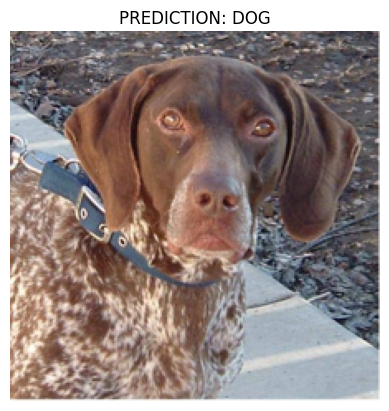

torch.Size([3, 224, 224])


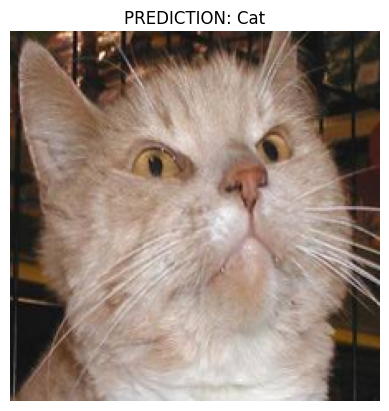

torch.Size([3, 224, 224])


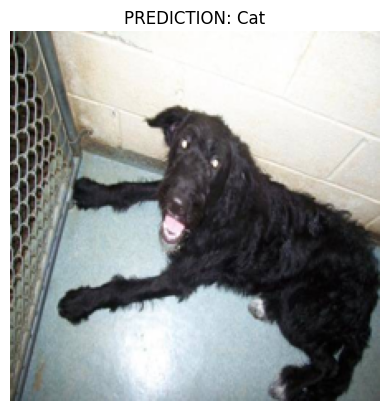

torch.Size([3, 224, 224])


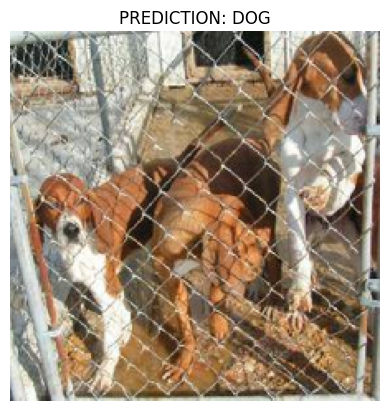

torch.Size([3, 224, 224])


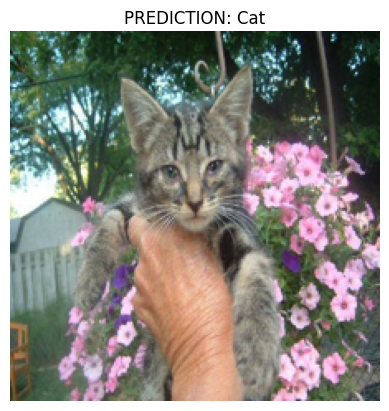

torch.Size([3, 224, 224])


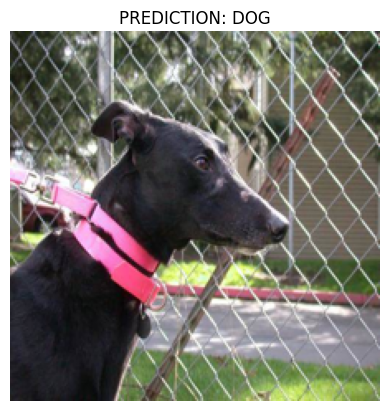

torch.Size([3, 224, 224])


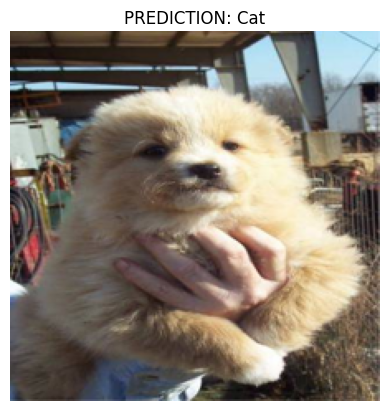

torch.Size([3, 224, 224])


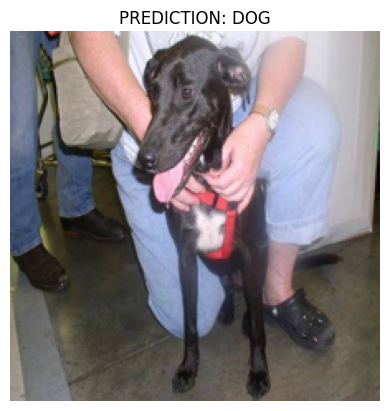

torch.Size([3, 224, 224])


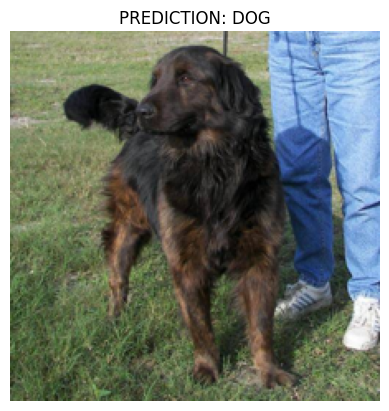

torch.Size([3, 224, 224])


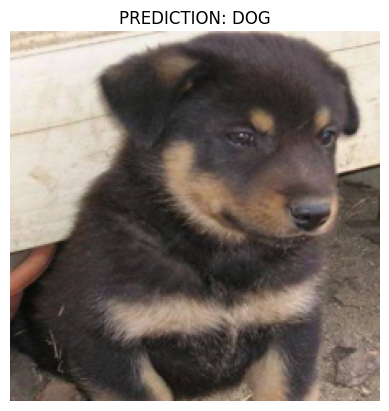

torch.Size([3, 224, 224])


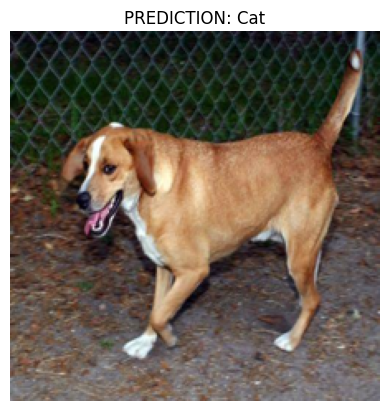

torch.Size([3, 224, 224])


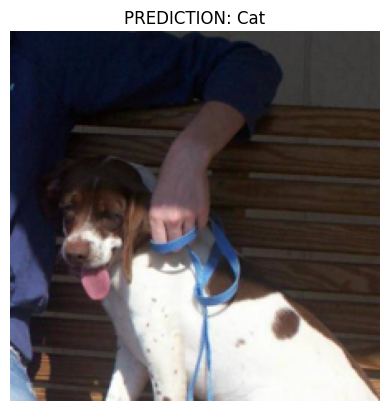

torch.Size([3, 224, 224])


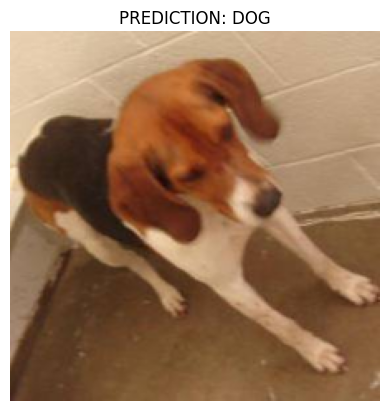

torch.Size([3, 224, 224])


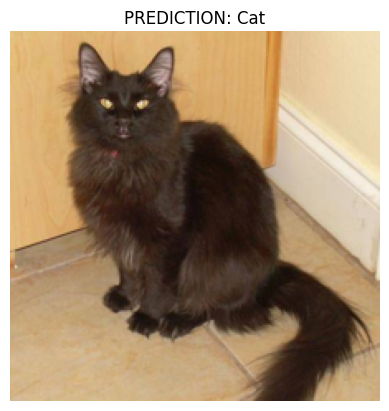

torch.Size([3, 224, 224])


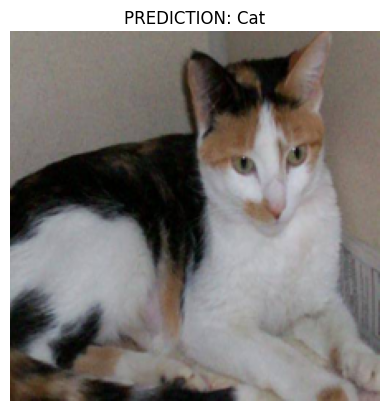

torch.Size([3, 224, 224])


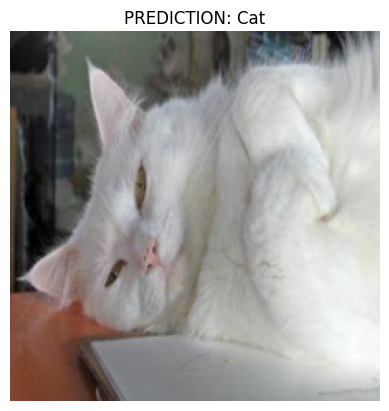

torch.Size([3, 224, 224])


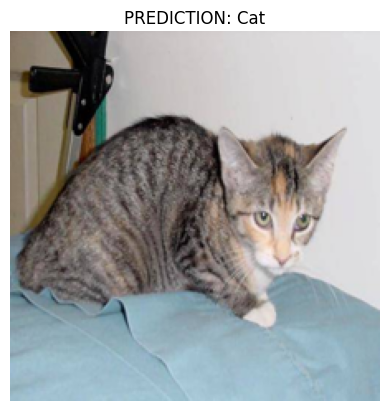

torch.Size([3, 224, 224])


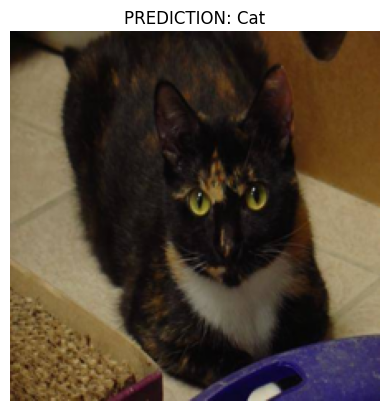

torch.Size([3, 224, 224])


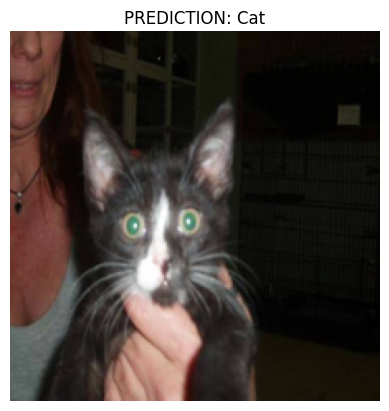

torch.Size([3, 224, 224])


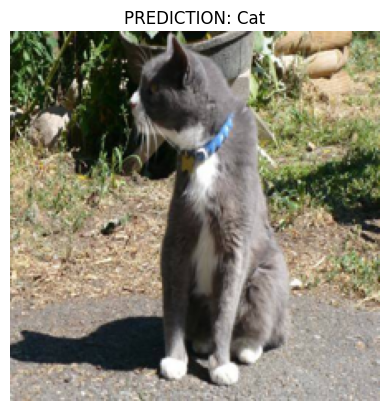

In [54]:
from PIL import Image
import random

# Since I normalized the data during training, the model should infer on normalized images
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])


test_dataset = os.listdir("/path/to/your/test1")
# Change to how many images you want to see
n_images = 20
for i in range(n_images):
    random_index = random.randint(0, len(test_dataset)-1)

    test_image = test_dataset[random_index]
    img = Image.open("/path/to/your/test1/"+test_image)
    test_img = transform(img)
    test_img.to(device)
    print(test_img.shape)

    model.eval()
    model.to(device)
    with torch.no_grad():
        prediction = model(test_img.to(device).unsqueeze(dim=0))
    # Since I used crossentropy, I need torch.argmax to get the classes.
    #{'cats': 0, 'dogs': 1}
    prediction_class = torch.argmax(prediction, dim=1) # Rows

    if float(prediction_class) == 0.0:
        prediction_class = "Cat"  
    else:
        prediction_class = "DOG" 

    # Use matplotlib to plot the image and the label

    img = test_img.permute(1,2,0)
    img = Image.open("/path/to/your/test1/"+test_image).resize((224,224))
    plt.title(f"PREDICTION: {prediction_class}")
    plt.axis(False)
    # Plot the unnormalized image
    plt.imshow(img)
    plt.show()
        